In [1]:
%matplotlib inline

In [2]:
import pandas
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import sklearn
import sklearn.linear_model
from datetime import datetime, date
from sklearn_pandas import DataFrameMapper
import warnings
import timeit
from collections import defaultdict, OrderedDict
import tabulate
import time
import GPy
import glob
from functools import reduce
from IPython.display import display
import filterpy

timeit.template = """
def inner(_it, _timer{init}):
    {setup}
    _t0 = _timer()
    for _i in _it:
        retval = {stmt}
    _t1 = _timer()
    return _t1 - _t0, retval
"""

matplotlib.style.use('ggplot')

RANDOM_SEED = 33

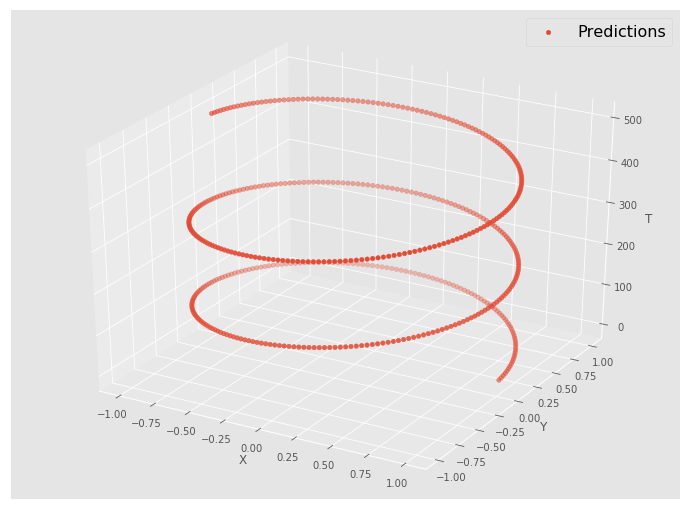

In [3]:
from filterpy.kalman import KalmanFilter
from filterpy.common import Q_discrete_white_noise
from mpl_toolkits.mplot3d import Axes3D

T_max = 500
theta = np.pi / 100

f = KalmanFilter (dim_x=2, dim_z=2)
f.x = np.array([np.cos(theta), np.sin(theta)])
f.F = np.array([[np.cos(theta), -np.sin(theta)], [np.sin(theta), np.cos(theta)]])
f.H = np.array([[1.0, 0.0]])
f.P *= 10
f.R = 0.1
f.Q = Q_discrete_white_noise(dim=2, dt=0.1, var=0.13)

predictions = []
for _ in range(T_max):
    predictions.append(f.x)
    f.predict()

x, y = zip(*predictions)

fig = plt.figure(figsize=(12, 9))
ax = fig.add_subplot(111, projection='3d')
ax.scatter(x, y, list(range(T_max)), cmap='bwr', label='Predictions')
ax.legend(loc='best', fontsize=16)
ax.set_xlabel('X', size=12)
ax.set_ylabel('Y', size=12)
ax.set_zlabel('T', size=12)

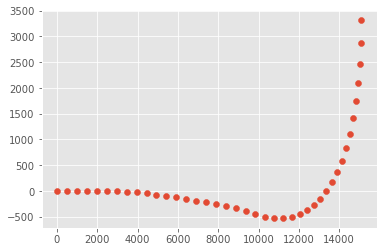

In [4]:
from filterpy.kalman import predict, update

# Variables relating to time:
t = 0.0
dt = 5.0
ENDTIME = 200.0
T = np.linspace(t, ENDTIME, int((ENDTIME - t) / dt + 1))
N_steps = len(T)


def actual_position(N):
    velocity = np.asarray([100, 0])
    pos = np.zeros((N, 2))

    for ind in range(1, N_steps):
        t = T[ind]
        pos[ind, :] = pos[ind - 1, :] + dt * velocity
        # Also add turbulence to velocity!
        velocity = velocity + np.random.randn(2)
        if 100 < t < 200:
            velocity = velocity + np.asarray([-5, +5])
    return pos


GROUND_TRUTH = actual_position(N_steps)
plt.figure()
plt.scatter(GROUND_TRUTH[:, 0], GROUND_TRUTH[:, 1], label="Actual trajectory")

In [13]:
f = KalmanFilter(dim_x=4, dim_z=2)
f.x = np.array([0, 0, 100, 0])
f.F = np.array([[1, 0, 5, 0], [0, 1, 0, 5], [0, 0, 1, 0], [0, 0, 0, 1]])
f.H = np.array([[1, 0, 0, 0], [0, 1, 0, 0]])
f.P *= 10
f.R = 500
f.Q = np.array([[0, 0, 0, 0], [0, 0, 0, 0], [0, 0, 1, 0], [0, 0, 0, 1]])
f.B = np.array([[0, 0], [0, 0], [1, 0], [0, 1]])


def read_sensor(ind, t):
    std = 500
    R = std * np.eye(2, 2)
    noise = std * np.random.randn(2)
    z = GROUND_TRUTH[ind] + noise
    return (z, R)


def control_action(t, z, R):
    if t >= 100:
        u = np.asarray([-5, +5])
    else:
        u = np.zeros(2)
    return u

[]

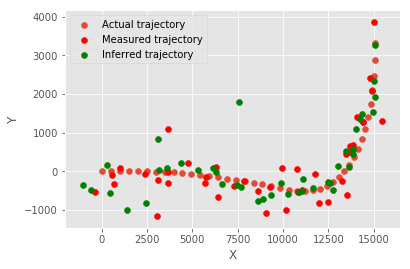

In [16]:
N_hidden_dim = 4
N_visible_dim = 2
N_control_dim = 2

# Maintain history for plotting purposes:
hist_t = np.zeros((N_steps, 1))
hist_x = np.zeros((N_steps, N_hidden_dim))
hist_z = np.zeros((N_steps, N_visible_dim))
hist_u = np.zeros((N_steps, N_control_dim))

# Run simulation
for (ind, t) in enumerate(T):
    z, R = read_sensor(ind, t)
    u = control_action(t, z, R)
    f.predict(u)
    f.update(z, R)

    # Append to history
    hist_t[ind] = t
    hist_x[ind, :] = f.x
    hist_z[ind, :] = z
    hist_u[ind, :] = u

# Now it's time to plot!
plt.figure()
plt.scatter(GROUND_TRUTH[:, 0], GROUND_TRUTH[:, 1], label="Actual trajectory")
plt.scatter(hist_z[:, 0], hist_z[:, 1], label="Measured trajectory", color='red')
plt.scatter(hist_x[:, 0], hist_x[:, 1], label="Inferred trajectory", color='green')
plt.xlabel('X')
plt.ylabel('Y')
plt.legend()
plt.plot()

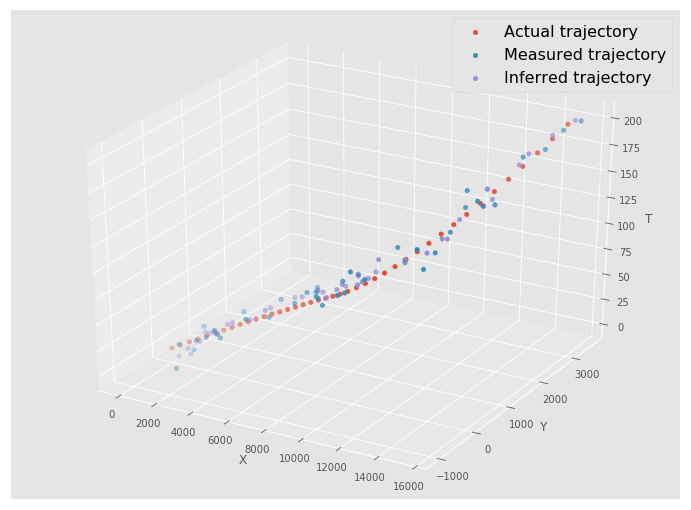

In [15]:
fig = plt.figure(figsize=(12, 9))
ax = fig.add_subplot(111, projection='3d')
ax.scatter(GROUND_TRUTH[:, 0], GROUND_TRUTH[:, 1], hist_t, label="Actual trajectory")
ax.scatter(hist_z[:, 0], hist_z[:, 1], hist_t, label="Measured trajectory")
ax.scatter(hist_x[:, 0], hist_x[:, 1], hist_t, label="Inferred trajectory")
ax.legend(loc='best', fontsize=16)
ax.set_xlabel('X', size=12)
ax.set_ylabel('Y', size=12)
ax.set_zlabel('T', size=12)